In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
import pylab as plt
from statsmodels.graphics.tsaplots import plot_acf

import functions as func

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# I. Exploratory Data Analysis

In [2]:
df = pd.read_csv('energy.dat')
df['Date'] = pd.to_datetime(df['Date'], format = '%d-%b-%y')
df = df.set_index('Date')

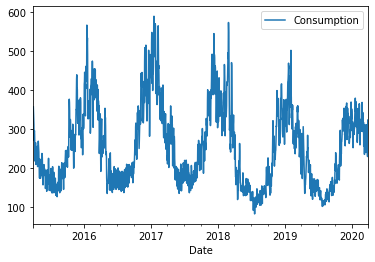

In [3]:
df.plot()

The chart of the energy consumption shows pronounced annual seasonality.

In [4]:
df['weekend'] = df.apply(lambda x: 1 if x.name.dayofweek > 4 else 0, axis = 1)
df['week'] = df.index.week

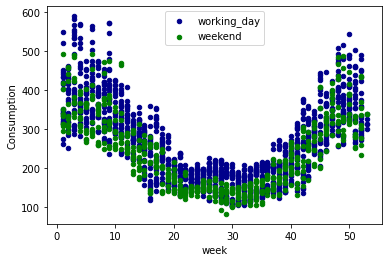

In [5]:
ax = df[df.weekend==0].plot.scatter(x='week',
                      y='Consumption',
                      c='DarkBlue', label = 'working_day')
df[df.weekend==1].plot.scatter(x='week',
                      y='Consumption',
                      c='Green', label = 'weekend', ax = ax)

The scatter plots of demand by week number shows that demand is higher during working days. However this relationship is less pronounced in winter as other factors, such as the number of HDD, play a more important role.

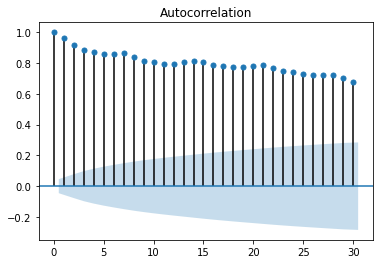

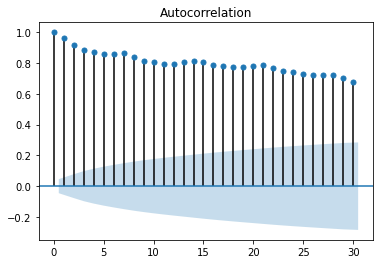

In [6]:
plot_acf(df.Consumption, lags = 30)

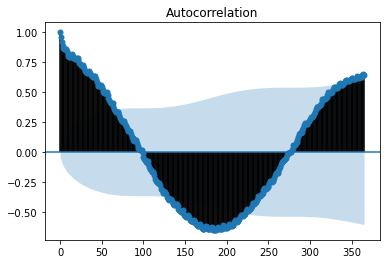

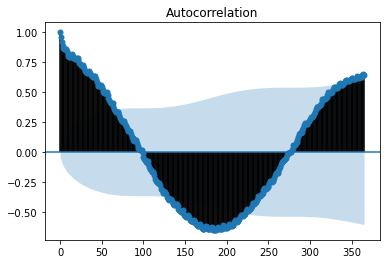

In [7]:
plot_acf(df.Consumption, lags = 365)

Energy demand data show strong autocorrelation.

# II. Select explanatory variables and train the model

In [8]:
#Add trend variable and seasonality variables
df['trend'] = df.apply(lambda x: (x.name - datetime.datetime(2015,4,1)).days, axis = 1)

df = func.seasonal_var (df, 365, 3)
#df = func.seasonal_var (df, 7, 3)

In [9]:
#Define specification of the model
mod = 'Consumption~ '
for i in df.columns[3:]:
    mod = mod + i +' + '
mod = mod[:-3]
print(mod)

Consumption~ trend + seas_365_1a + seas_365_1b + seas_365_2a + seas_365_2b + seas_365_3a + seas_365_3b


In [10]:
#Train the model
fitted_reg = pd.DataFrame()
residuals = pd.DataFrame()

lr = LinearRegression()
y,X = dmatrices (mod, df, return_type = 'dataframe')
lr.fit(X,y)
model = smf.ols(formula = mod, data = df).fit()

print(model.summary())

np.savetxt('params/'+mod.split('~')[0]+'_coef.csv', lr.coef_) #, delimeter = ','
np.savetxt('params/'+mod.split('~')[0]+'_intercept.csv', lr.intercept_)
np.savetxt('params/'+mod.split('~')[0]+'_model.csv', [mod], fmt = '%s')

fitted_reg[mod.split('~')[0]] = model.fittedvalues
residuals[mod.split('~')[0]] = model.resid

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1140.
Date:                Sun, 14 Nov 2021   Prob (F-statistic):               0.00
Time:                        19:33:31   Log-Likelihood:                -9878.7
No. Observations:                1827   AIC:                         1.977e+04
Df Residuals:                    1822   BIC:                         1.979e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     296.2598      2.559    115.770      

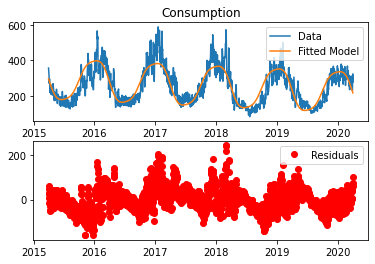

In [11]:
plt.figure()
plt.subplot(211)
plt.plot(df[mod.split('~')[0]].loc[df[mod.split('~')[0]].first_valid_index():df[mod.split('~')[0]].last_valid_index()])
plt.plot(model.fittedvalues.loc[model.fittedvalues.first_valid_index():model.fittedvalues.last_valid_index()])
plt.legend(['Data', 'Fitted Model'])
plt.title(mod.split('~')[0])
plt.subplot(212)
plt.plot(model.resid.loc[model.resid.first_valid_index():model.resid.last_valid_index()], 'ro')
plt.legend(['Residuals'])
plt.show()

# III. Produce the forecast

In [12]:
output = pd.DataFrame(index = pd.date_range(start = '2020-04-01', end = '2022-03-31'), columns = ['trend'])
output['trend'] = output.apply(lambda x: (x.name - datetime.datetime(2015,4,1)).days, axis = 1)
output = func.seasonal_var (output, 365, 3)
output['Consumption'] = 0

In [13]:
mod.split('~')[0]

'Consumption'

In [14]:
demand_forecast = pd.DataFrame()
y,X = dmatrices(mod, output, return_type = 'dataframe')
lr = LinearRegression()
coefs = np.genfromtxt('params/'+mod.split('~')[0]+'_coef.csv')
intercepts = np.genfromtxt('params/'+mod.split('~')[0]+'_intercept.csv')
lr.intercept_ = intercepts
lr.coef_ = coefs
f = lr.predict(X)
demand_forecast = pd.DataFrame(f, index = X.index, columns=['Forecast'])

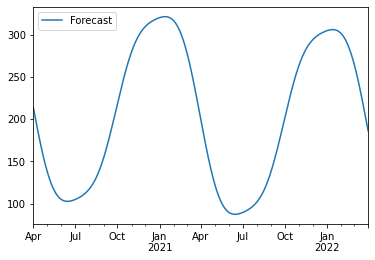

In [15]:
demand_forecast.plot()

In [16]:
fin = pd.DataFrame(index = pd.date_range(start = '2015-04-01', end = '2022-03-31'), columns = ['Actual', 'Forecast'])
fin.Actual = fin.apply(lambda x: df[df.index==x.name]['Consumption'].iloc[0] if not(df[df.index==x.name]['Consumption'].empty) else np.nan, axis = 1)
fin.Forecast = fin.apply(lambda x: demand_forecast[demand_forecast.index==x.name]['Forecast'].iloc[0] if not(demand_forecast[demand_forecast.index==x.name]['Forecast'].empty) else np.nan, axis = 1)

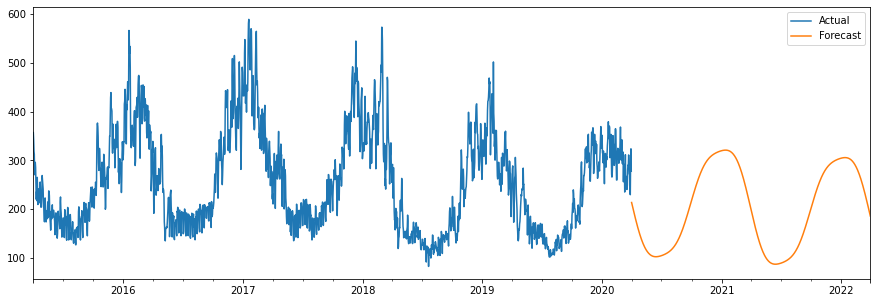

In [17]:
#Plot actual consumption and produced forecast
fin.plot(figsize = (15,5))

In [18]:
fin.to_csv('output/output.csv')